In [91]:
from Dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch
import VAE
from Model_Wrapper import Wrapper
import matplotlib.pyplot as plt
import helper
from torchinfo import summary
import numpy as np 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
# !bash download.sh afhq-dataset

In [94]:
# Create a dataset and a DataLoader
transforms = {'val':transforms.Compose([
    transforms.Resize([64, 64]),  # Resize the image first
    transforms.ToTensor(),        # Convert PIL image to tensor
    # transforms.Normalize(mean=[0.5], std=[0.5]) 
]),
'train':transforms.Compose([
    transforms.Resize([64, 64]),  # Resize the image first
    # transforms.RandomHorizontalFlip(p=0.5),       # Random horizontal flip
    transforms.ToTensor(),        # Convert PIL image to tensor
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for a single channel
])
}


root_dir = "/home/user/elwakeely1/Cuda_Vision_Lab-/Session5/Solution/data/afhq"

# Initialize dataset
train_dataset = Dataset(root_dir=root_dir, split="train", transform=transforms["train"])
test_dataset = Dataset(root_dir=root_dir, split="val", transform=transforms["val"])


In [95]:
print(f"train size: {train_dataset.__len__()}\ntest size: {test_dataset.__len__()}")

train size: 14630
test size: 1500


In [96]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,num_workers=8,pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,num_workers=8,pin_memory=True)
print("test_dataset per epoch",next(iter(test_loader))[0].size())

test_dataset per epoch torch.Size([64, 1, 64, 64])


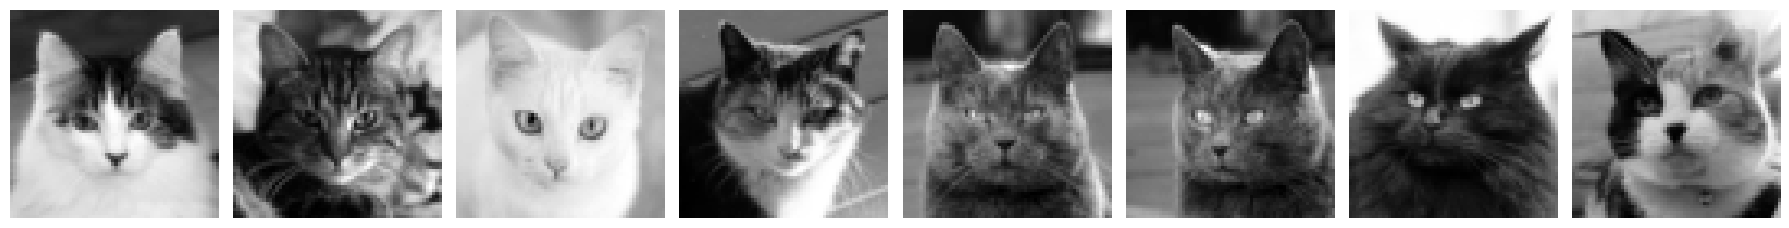

In [97]:
imgs, _ = next(iter(test_loader)) 
fig, ax = plt.subplots(1, 8, figsize=(18, 5))  
for i in range(8):
    ax[i].imshow(imgs[i].squeeze(0), cmap="gray")  
    ax[i].axis("off")
plt.tight_layout()
plt.show()

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Kullback-Leibler Divergence (KLD): 
encourages the latent space to match a standard normal distribution.

Weighting Parameter (lambda_kld):
lambda_kld scales the KLD term to balance its importance relative to the reconstruction loss.
A smaller value (e.g.,10^-3) emphasizes reconstruction more, while a larger value gives more weight to the KLD.
This is the closed-form solution for KLD between two Gaussian distributions.

In [99]:
vae = VAE.VanillaVAE(in_size=(1,64,64), sizes=[4096, 1256, 512, 16], act="ReLU")
vae = vae.to(device)
summary(vae,input_size=((1,64,64)))

Layer (type:depth-idx)                   Output Shape              Param #
VanillaVAE                               [1, 1, 64, 64]            --
├─Sequential: 1-1                        [1, 512]                  643,584
│    └─Flatten: 2-1                      [1, 4096]                 --
│    └─Linear: 2-2                       [1, 1256]                 5,145,832
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-3                         [1, 1256]                 --
├─Sequential: 1-3                        --                        (recursive)
│    └─Linear: 2-4                       [1, 512]                  643,584
├─Sequential: 1-4                        --                        (recursive)
│    └─ReLU: 2-5                         [1, 512]                  --
├─Linear: 1-5                            [1, 16]                   8,208
├─Linear: 1-6                            [1, 16]                   8,208
├─Sequential: 1-7                  

In [100]:
optimizer = torch.optim.Adam(vae.parameters(), lr=3e-3)
# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.1, verbose=True)

In [101]:
writer = helper.new_writer("models","VanillaVAE")
train = Wrapper(model_name="VanillaVAE", model = vae, device = device, criterion = helper.vae_loss_function, optimizer = optimizer,writer=writer,show_progress_bar= True)
train.train(10,train_loader,test_loader)
writer.close()

Epoch 1 Iter 229: loss 0.04538.: 100%|██████████| 229/229 [00:05<00:00, 44.06it/s]

Train Loss 0.05231


Test Loss 0.0454
    Test recons_Loss 0.04243
    Test kld_Loss 2.97321


Epoch 2 Iter 229: loss 0.04226.: 100%|██████████| 229/229 [00:05<00:00, 43.83it/s]

Train Loss 0.04319


Test Loss 0.04138
    Test recons_Loss 0.03722
    Test kld_Loss 4.16488


Epoch 3 Iter 229: loss 0.03779.: 100%|██████████| 229/229 [00:05<00:00, 42.66it/s]

Train Loss 0.03925


Test Loss 0.03764
    Test recons_Loss 0.03338
    Test kld_Loss 4.25397


Epoch 4 Iter 229: loss 0.03809.: 100%|██████████| 229/229 [00:05<00:00, 45.33it/s]

Train Loss 0.03784


Test Loss 0.0372
    Test recons_Loss 0.03266
    Test kld_Loss 4.53912


Epoch 5 Iter 229: loss 0.03586.: 100%|██████████| 229/229 [00:05<00:00, 44.36it/s]

Train Loss 0.03754


Test Loss 0.03713
    Test recons_Loss 0.03299
    Test kld_Loss 4.1347


Epoch 6 Iter 229: loss 0.03523.: 100%|██████████| 229/229 [00:05<00:00, 44.91it/s]

Train Loss 0.03725


Test Loss 0.03666
    Test recons_Loss 0.03259
    Test kld_Loss 4.07771


Epoch 7 Iter 229: loss 0.03621.: 100%|██████████| 229/229 [00:04<00:00, 46.07it/s]

Train Loss 0.03642


Test Loss 0.03584
    Test recons_Loss 0.03121
    Test kld_Loss 4.63154


Epoch 8 Iter 229: loss 0.03922.: 100%|██████████| 229/229 [00:05<00:00, 43.43it/s]

Train Loss 0.03538


Test Loss 0.03492
    Test recons_Loss 0.03023
    Test kld_Loss 4.68785


Epoch 9 Iter 229: loss 0.03539.: 100%|██████████| 229/229 [00:05<00:00, 45.23it/s]

Train Loss 0.03518


Test Loss 0.03506
    Test recons_Loss 0.03059
    Test kld_Loss 4.47854


Epoch 10 Iter 229: loss 0.03485.: 100%|██████████| 229/229 [00:05<00:00, 44.50it/s]

Train Loss 0.03512


Test Loss 0.03482
    Test recons_Loss 0.02992
    Test kld_Loss 4.90307


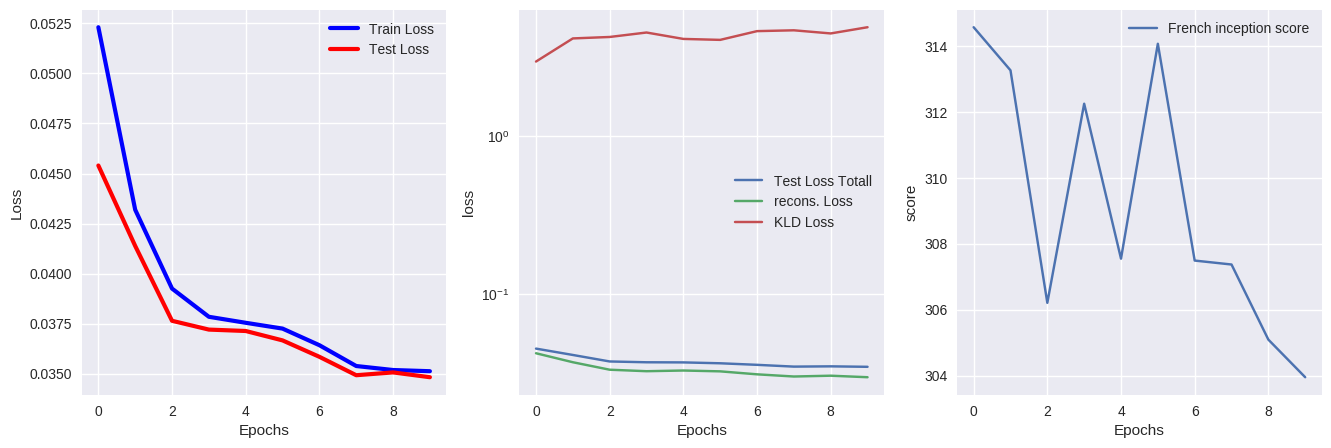

In [102]:
train.plot_loss_acc()

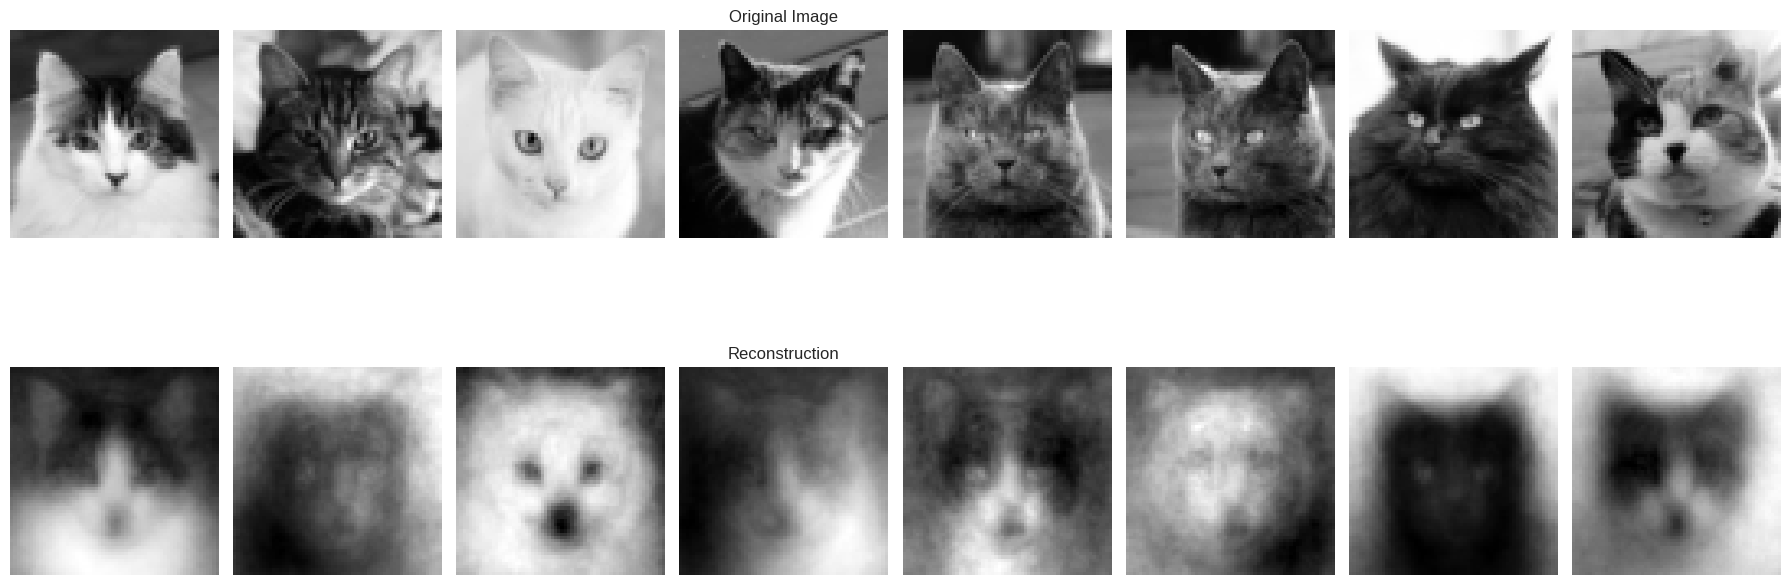

In [103]:
imgs, _ = next(iter(test_loader)) 

vae.eval()
with torch.no_grad():
    recons, _ = vae(imgs.to(device))
    
fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 8)
for i in range(8):
    ax[0, i].imshow(imgs[i, 0], cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].imshow(recons[i, 0].cpu(), cmap="gray")
    ax[1, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()

In [104]:
# our latent space (bottleneck) is 64-dim
LATENT_DIM = 16
NUM_SAMPLES = 10

latents = torch.randn((NUM_SAMPLES, LATENT_DIM), device=device)
with torch.no_grad():
    gen_imgs = vae.decoder(latents)
    gen_imgs = gen_imgs.reshape(NUM_SAMPLES, 1, 64, 64)

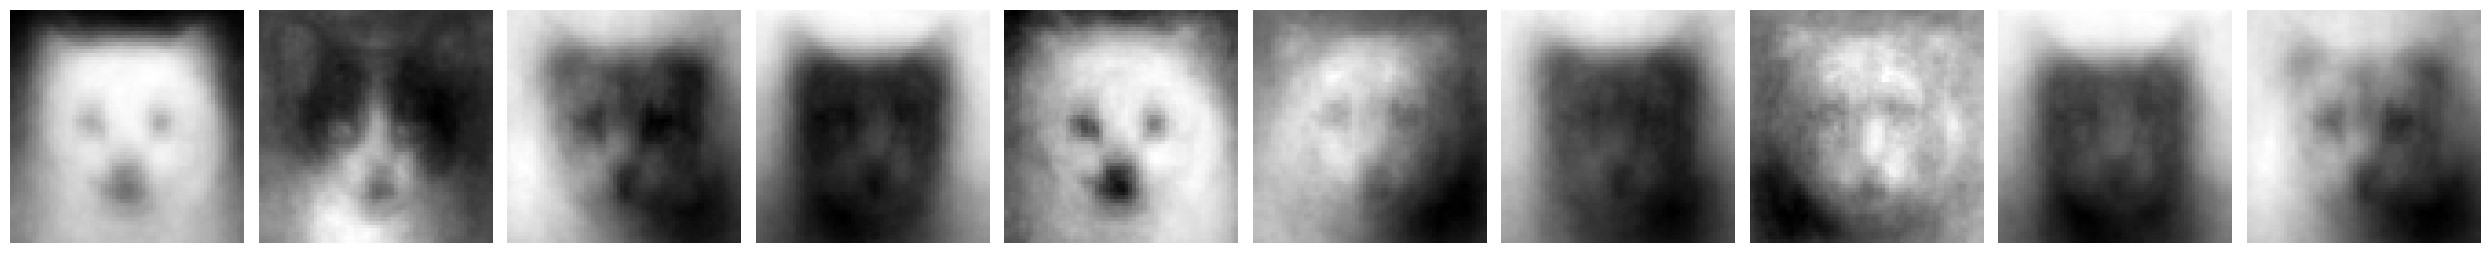

In [105]:
fig, ax = plt.subplots(1, 10)
fig.set_size_inches(25, 3)
for i in range(10):
    ax[i].imshow(gen_imgs[i, 0].cpu(), cmap="gray")
    ax[i].axis("off")
fig.tight_layout()
plt.show()

In [106]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = vae(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

In [107]:
COLORS = ['r','b','g']
def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")

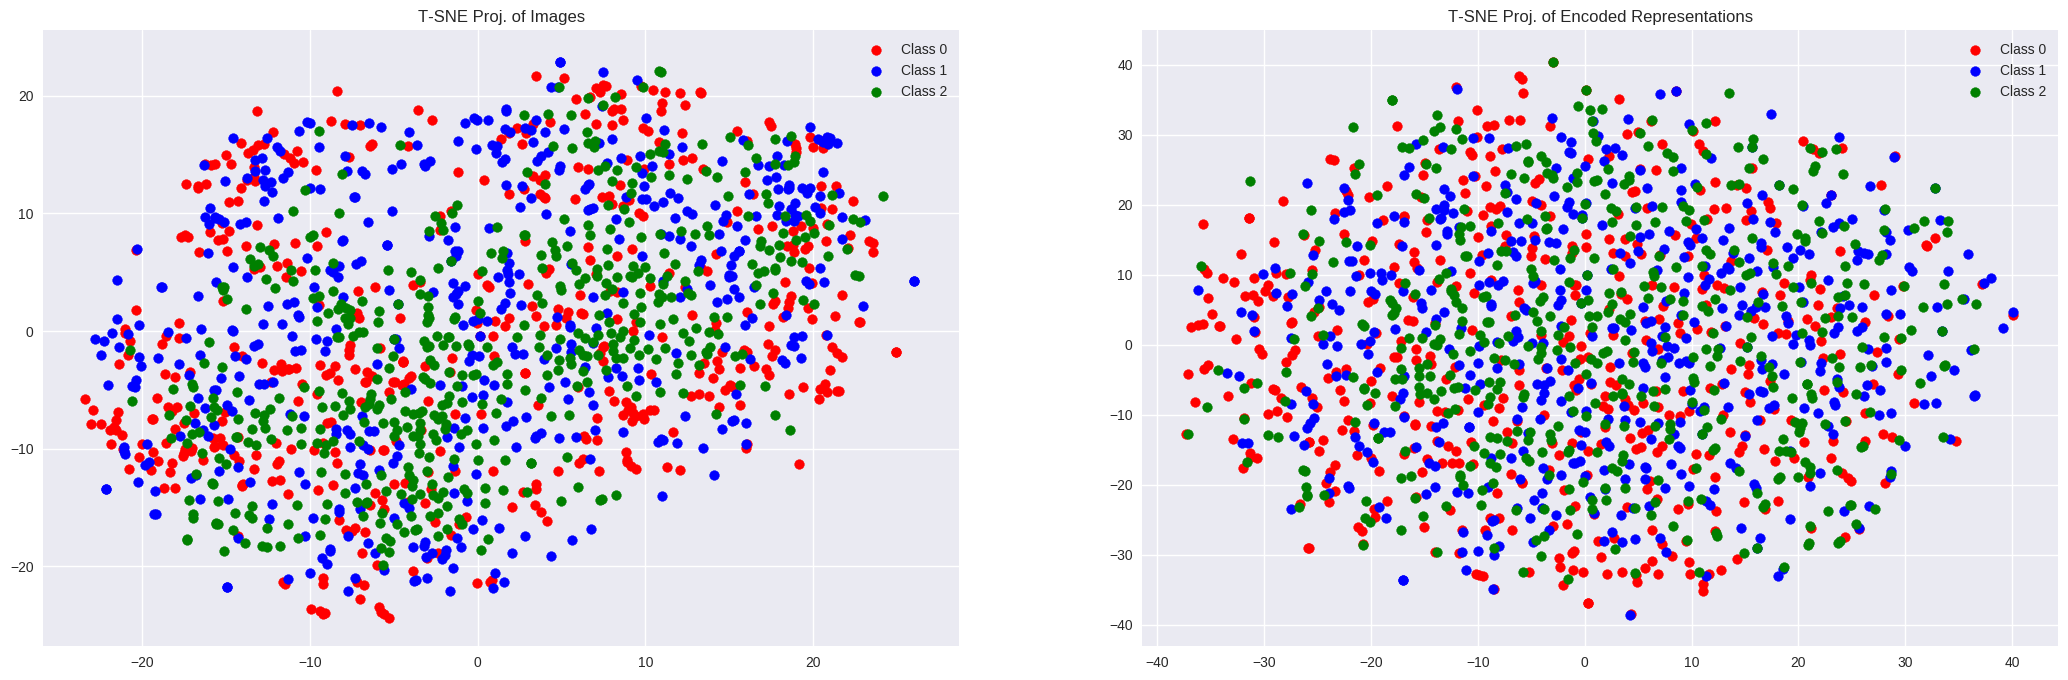

In [108]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_latents = TSNE(n_components=2).fit_transform(latents[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0])
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:N], labels[:N], ax=ax[1])
ax[1].set_title("T-SNE Proj. of Encoded Representations")
plt.show()

# Convolution Variational autoencoder 

In [109]:
LATENT_DIM = 10
conv_vae = VAE.ConvVAE(latent_dim=LATENT_DIM)
conv_vae = conv_vae.to(device)
summary(conv_vae,input_size=(1,64,64))

Layer (type:depth-idx)                   Output Shape              Param #
ConvVAE                                  [1, 1, 64, 64]            --
├─Sequential: 1-1                        [256, 4, 4]               --
│    └─Conv2d: 2-1                       [32, 32, 32]              544
│    └─ReLU: 2-2                         [32, 32, 32]              --
│    └─Conv2d: 2-3                       [64, 16, 16]              32,832
│    └─ReLU: 2-4                         [64, 16, 16]              --
│    └─Conv2d: 2-5                       [128, 8, 8]               131,200
│    └─ReLU: 2-6                         [128, 8, 8]               --
│    └─Conv2d: 2-7                       [256, 4, 4]               524,544
├─Linear: 1-2                            [1, 10]                   40,970
├─Linear: 1-3                            [1, 10]                   40,970
├─Linear: 1-4                            [1, 4096]                 45,056
├─Sequential: 1-5                        [1, 1, 64, 64]   

In [110]:
optimizer = torch.optim.Adam(conv_vae.parameters(), lr=3e-3)
# Decay LR by a factor of 10 after 5 epochs with no improvement
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.1, verbose=True)

/home/user/elwakeely1/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [111]:
writer = helper.new_writer("models","ConvVAE")
train = Wrapper(model_name="COnvVAE", model = conv_vae, device = device, criterion = helper.vae_loss_function, optimizer = optimizer,writer=writer,show_progress_bar= True)
train.train(5,train_loader,test_loader)
writer.close()

Epoch 1 Iter 229: loss 0.05995.: 100%|██████████| 229/229 [00:05<00:00, 43.12it/s]

Train Loss 0.0532


Test Loss 0.05292
    Test recons_Loss 0.05292
    Test kld_Loss 0.00021


Epoch 2 Iter 229: loss 0.05603.: 100%|██████████| 229/229 [00:05<00:00, 43.83it/s]

Train Loss 0.053


OutOfMemoryError: CUDA out of memory. Tried to allocate 338.00 MiB. GPU 0 has a total capacity of 10.75 GiB of which 265.56 MiB is free. Process 1897383 has 7.58 GiB memory in use. Including non-PyTorch memory, this process has 2.88 GiB memory in use. Of the allocated memory 1.97 GiB is allocated by PyTorch, and 736.02 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

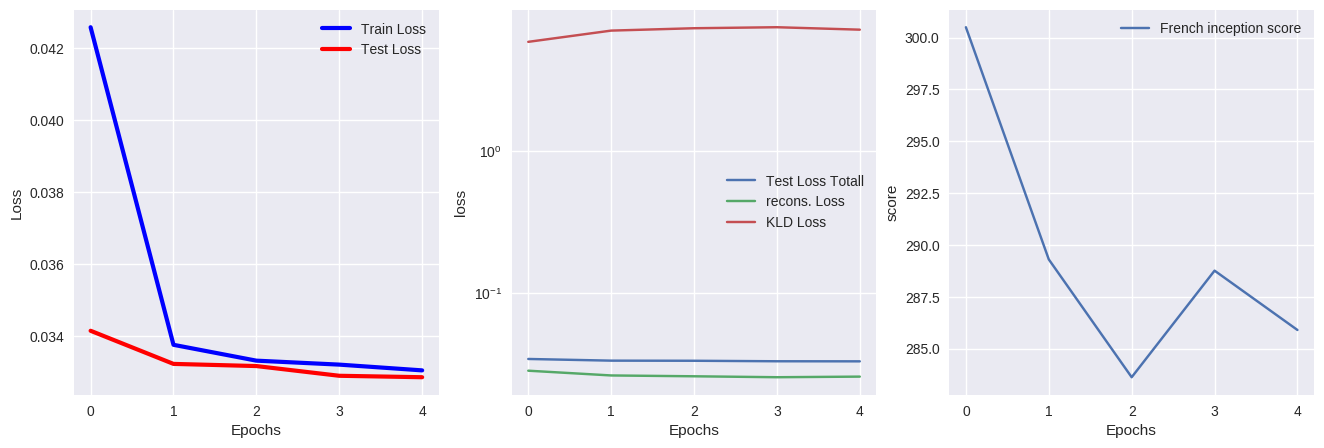

In [67]:
train.plot_loss_acc()

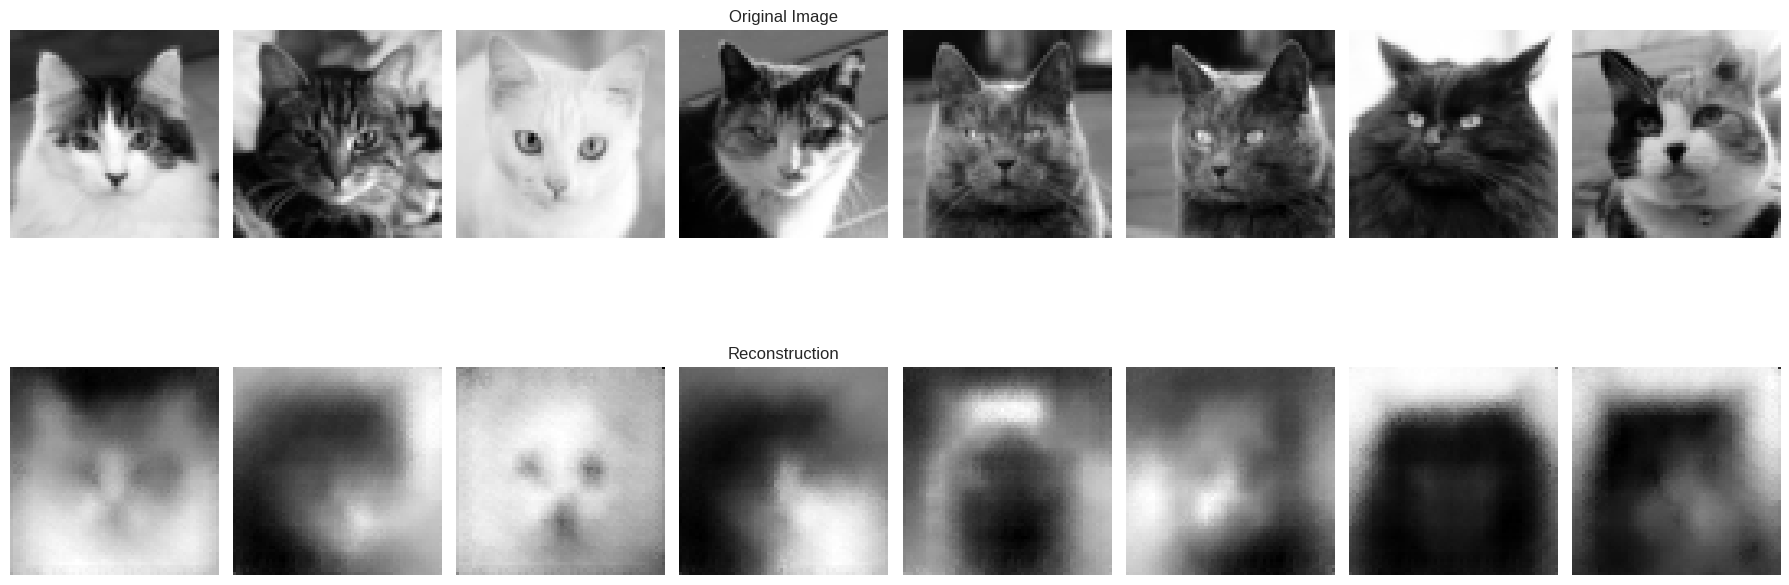

In [ ]:
imgs, _ = next(iter(test_loader)) 

conv_vae.eval()
with torch.no_grad():
    recons, _ = conv_vae(imgs.to(device))
    
fig, ax = plt.subplots(2, 8)
fig.set_size_inches(18, 8)
for i in range(8):
    ax[0, i].imshow(imgs[i, 0], cmap="gray")
    ax[0, i].axis("off")
    ax[1, i].imshow(recons[i, 0].cpu(), cmap="gray")
    ax[1, i].axis("off")

ax[0, 3].set_title("Original Image")
ax[1, 3].set_title("Reconstruction")
plt.tight_layout()
plt.show()

In [69]:
# our latent space (bottleneck) is 64-dim
NUM_SAMPLES = 10

latents = torch.randn((NUM_SAMPLES, LATENT_DIM), device=device)
with torch.no_grad():
    gen_imgs =conv_vae.decode(latents)
    gen_imgs = gen_imgs.reshape(NUM_SAMPLES, 1, 64, 64)

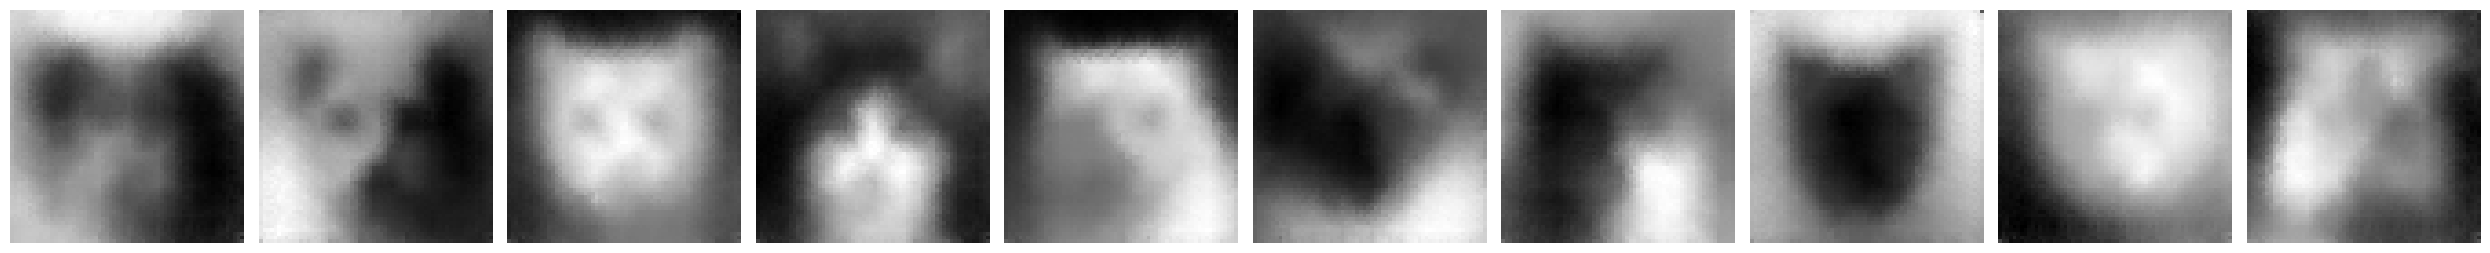

In [ ]:
fig, ax = plt.subplots(1, 10)
fig.set_size_inches(25, 3)
for i in range(10):
    ax[i].imshow(gen_imgs[i, 0].cpu(), cmap="gray")
    ax[i].axis("off")
fig.tight_layout()
plt.show()

In [71]:
imgs_flat, latents, labels = [], [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(device)
        _, (z, _, _) = conv_vae(imgs)
        imgs_flat.append(imgs.cpu().view(imgs.shape[0],-1))
        latents.append(z.cpu())
        labels.append(lbls)
        
imgs_flat = np.concatenate(imgs_flat)    
latents = np.concatenate(latents)
labels = np.concatenate(labels)

In [72]:
COLORS = ['r','b','g']
def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")

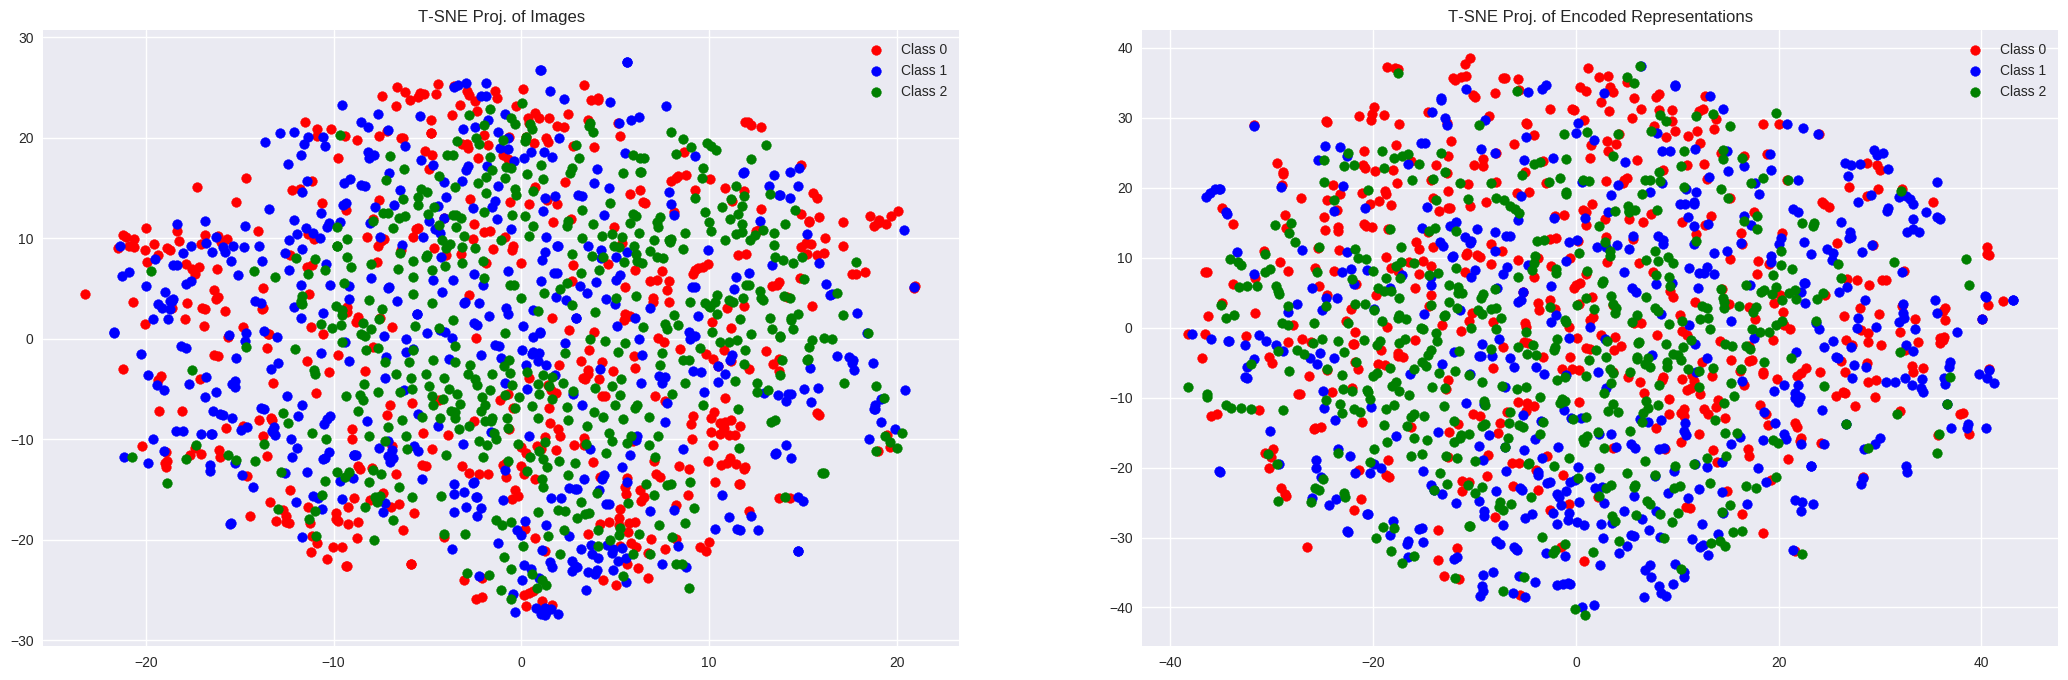

In [ ]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(imgs_flat[:N])
tsne_latents = TSNE(n_components=2).fit_transform(latents[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0])
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:N], labels[:N], ax=ax[1])
ax[1].set_title("T-SNE Proj. of Encoded Representations")
plt.show()

# Interpolation

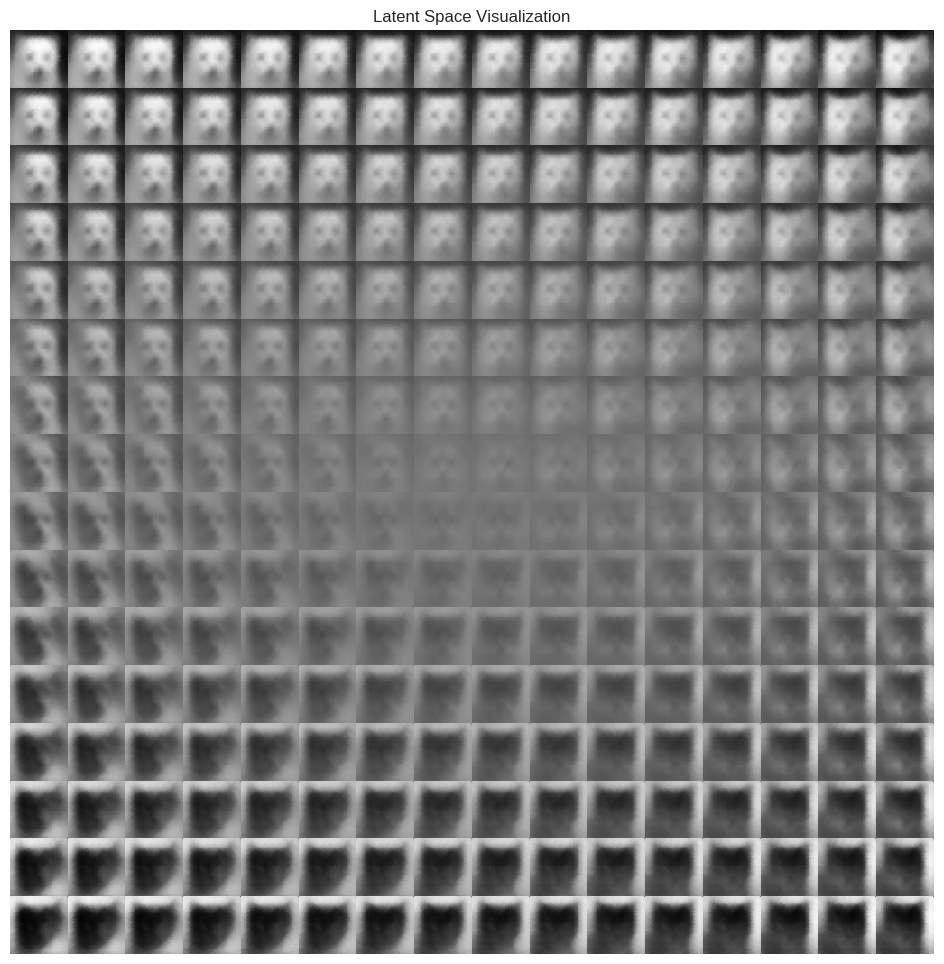

In [ ]:
@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-3, 3), resolution=12, image_size=32):
    """
    Sampling equispaced points from the latent space given the xrange and yrange, 
    decoding latents and visualizing the distribution of the latent space.
    """
    # Generate equispaced points in the latent space
    x = torch.linspace(*xrange, resolution, device=device)
    y = torch.linspace(*yrange, resolution, device=device)
    xx, yy = torch.meshgrid(x, y, indexing='ij')

    # Create latent vectors
    latent_grid = torch.zeros((resolution**2, model.latent_dim), device=device)
    latent_grid[:, 0] = xx.flatten()
    latent_grid[:, 1] = yy.flatten()

    # Decode latents
    gen_imgs = model.decode(latent_grid).cpu()
    gen_imgs = gen_imgs.view(-1, image_size, image_size).numpy()

    # Arrange decoded images into a grid
    grid = np.empty((resolution * image_size, resolution * image_size))
    for i in range(resolution):
        for j in range(resolution):
            img_idx = i * resolution + j
            grid[
                i * image_size:(i + 1) * image_size,
                j * image_size:(j + 1) * image_size,
            ] = gen_imgs[img_idx]

    # Plot the grid
    plt.figure(figsize=(12, 12))
    plt.imshow(grid, extent=[*xrange, *yrange], cmap="gray")
    plt.axis("off")
    plt.title("Latent Space Visualization")
    plt.show()

plot_reconstructed(conv_vae, xrange=(-3, 3), yrange=(-3, 3), resolution=16, image_size=64)


# Clustering 

In [112]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [125]:
kmeans_imgs = KMeans(n_clusters=2, random_state=0).fit(imgs_flat)
kmeans_latent = KMeans(n_clusters=2, random_state=0).fit(latents)

/home/user/elwakeely1/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/user/elwakeely1/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [126]:
ari_imgs = adjusted_rand_score(labels, kmeans_imgs.labels_)
ari_latents = adjusted_rand_score(labels, kmeans_latent.labels_)

In [127]:
print(f"Clustering images achieves  ARI={round(ari_imgs*100,2)}%")
print(f"Clustering latents achieves ARI={round(ari_latents*100,2)}%")

Clustering images achieves  ARI=-0.06%
Clustering latents achieves ARI=0.81%


In [128]:
print(f"Compression ratio: {latents.shape[-1]}/{imgs_flat.shape[-1]}  = {round(latents.shape[-1]/imgs_flat.shape[-1] * 100, 2)}%")

Compression ratio: 16/4096  = 0.39%
